In [287]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC df_predictorsset, target variabels to predict are the relative commercial content losses [fraction of content loss and total content value ] of shophouses and their business reduction [% reduction in a month]

BN package: https://github.com/mike-mendoza/py_banshee

In [288]:
import sys, os
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import mpl_scatter_density # adds projection="scatter_density"
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


# sys.path.insert(0, "../")
UTILS_PATH = os.path.join(os.path.abspath(""), "../", "utils")
sys.path.append(UTILS_PATH)
import settings as s
import figures as f
import evaluation_metrics as em

seed = s.seed
pd.set_option("display.max_columns", None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings("ignore")

target = "Target_businessreduction"

## save models and their evaluation in following folders:
Path(f"../../model_results/bayesian_network/businessreduction").mkdir(parents=True, exist_ok=True)


In [289]:
## load train set for BN (HCMC, bred)
target_name = "businessreduction"
df_hcmc = pd.read_excel(f"../model_results/selected_features/degree_of_loss/final_predictors_Target_{target_name}.xlsx")
df_hcmc.drop("geometry", axis=1, inplace=True)
print(df_hcmc.shape)
print(df_hcmc.tail(2))


## load hold out set (HCMC, bred)input_data_contentloss_tueb_holdout
df_hcmc_holdout = pd.read_excel(f"../input_survey_data/input_data_{target_name}_tueb_holdout.xlsx")
df_hcmc_holdout = df_hcmc_holdout[df_hcmc.columns]  # update only with identified loss-drivers
# df_hcmc_holdout.drop("geometry", axis=1, inplace=True)
print(df_hcmc_holdout.shape)
print(df_hcmc_holdout.tail(2))


(356, 14)
     Target_businessreduction  flowvelocity  emergency_measures   
354                         0           0.3            0.333333  \
355                        20           0.3            0.666667   

     water_depth_cm  bage  resilience  flood_experience  b_area   
354            30.0   5.0         3.0                76    48.0  \
355            10.0  57.0         2.0               151    56.0   

     inundation_duration_h  shp_employees  precautionary_measures_expensive   
354                    1.0              1                               0.0  \
355                    3.0              1                               0.0   

     precautionary_measures_lowcost  shp_avgmonthly_sale_euro  contaminations  
354                            0.25                      92.1               0  
355                            0.25                      92.1               1  
(0, 14)
Empty DataFrame
Columns: [Target_businessreduction, flowvelocity, emergency_measures, water_depth_cm

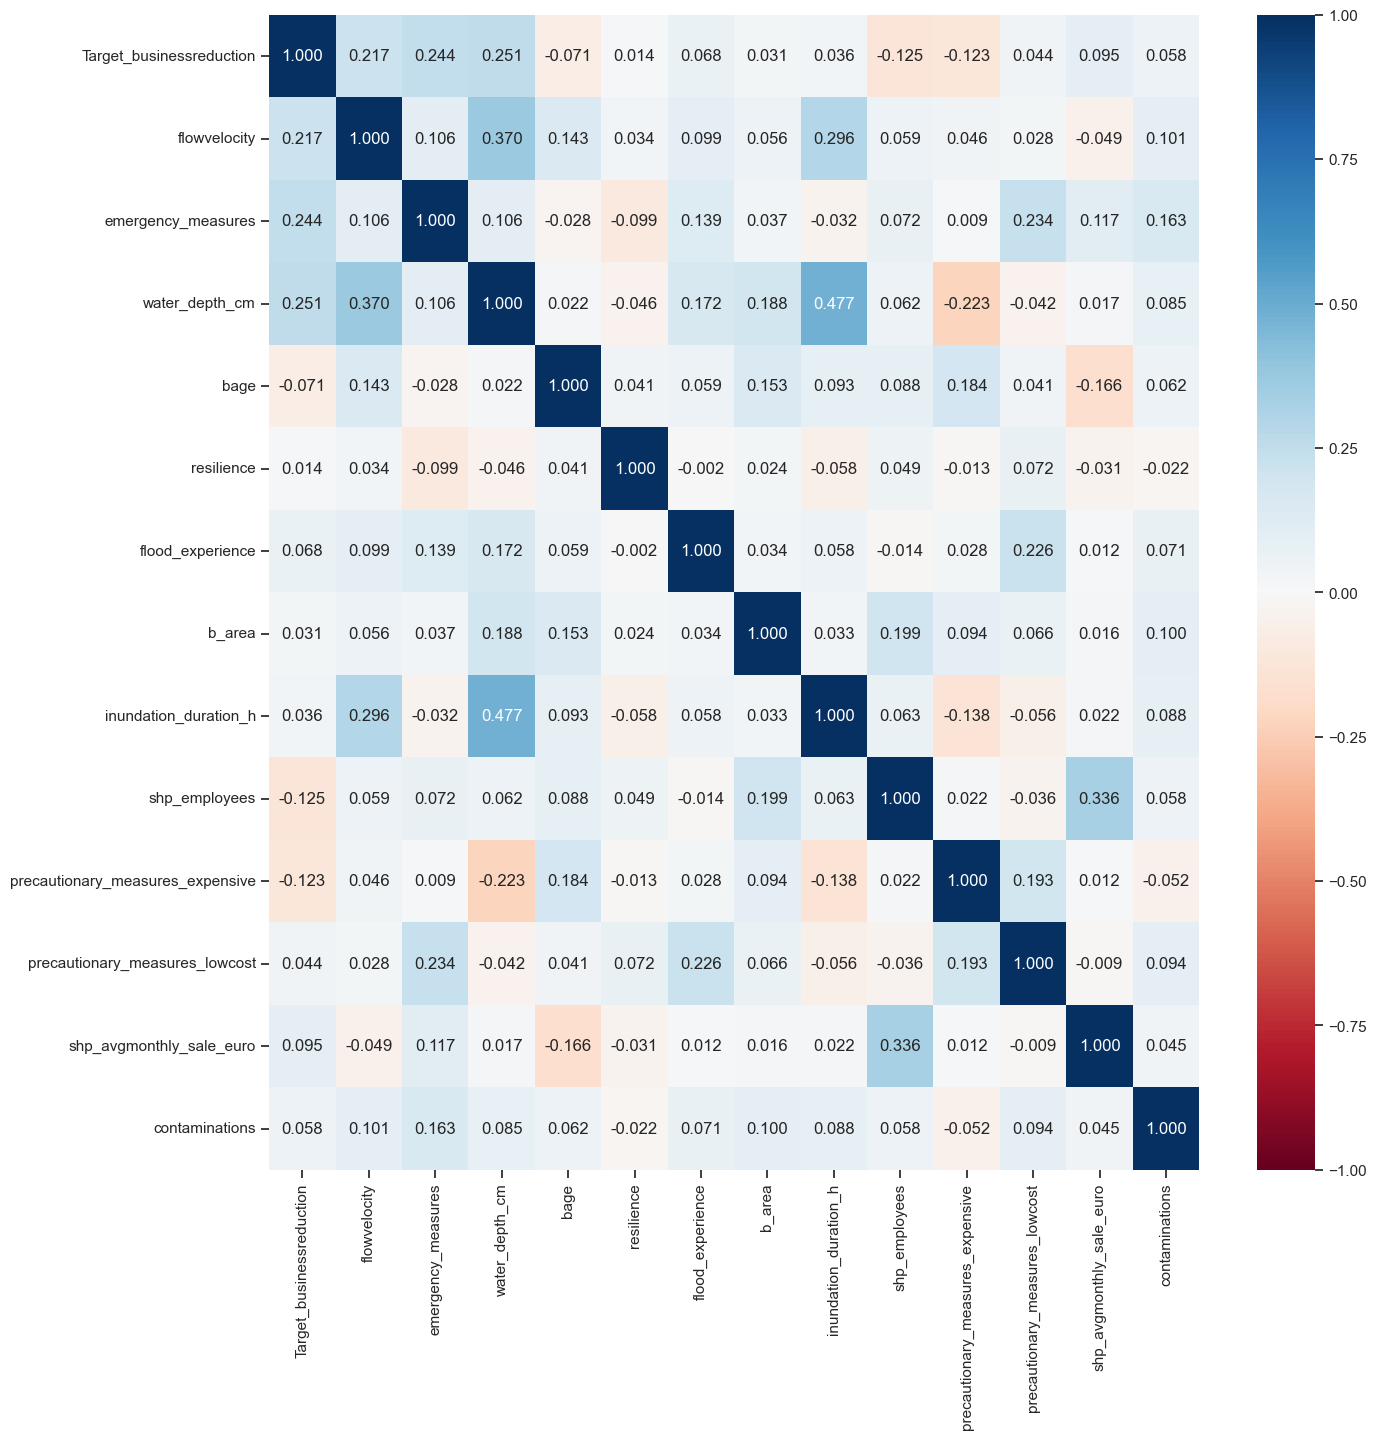

In [290]:
## find predictor with highest unconditional correlation to target
# f.plot_spearman_rank(df_hcmc)
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_hcmc.corr(method="spearman"), 
                      vmin=-1, vmax=1, 
                      annot=True, fmt=".3f", 
                      cmap="RdBu")

# fv most corr ~ target

--> water depth correlates strongest with rcloss

In [291]:
# dd = df_hcmc.loc[df_hcmc.inundation_duration_h < 30, :]
# print(df_hcmc.shape, dd.shape)
# # sns.regplot(x=dd.flowvelocity, y=dd.inundation_duration_h)
# f.plot_correlations(dd[[target, "flowvelocity", "inundation_duration_h", "water_depth_cm"]], 
#                     impute_na=True, outfile=f"../figures/tst.png")

## Copula test

In [292]:
# #-----------------------------------------------------------------------------
# # Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
# #-----------------------------------------------------------------------------

# M = cvm_statistic(df_hcmc,                   # df_predictorsFrame with df_hcmc
#                   names = df_hcmc.columns,   # names of variables
#                   plot = True,               # create a plot (0=don"t create plot)
#                   fig_name = "empricial_corpula_all vars_bred")    # figure name
                  
# # The results of the goodness-of-fit test in terms of Cramer-von Mises
# # statistic highlight that the Gaussian copula is in majority of cases the 
# # most suitable for representing the dependency between variables, 
# # especially for the variable of interest (safety). This is important as
# # the method utilizes the Gaussian copula for dependence modelling.


# ## !! decalibration score = overall score if BN fullfills 

## Contruct BN

In [293]:

# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f"bn_{target}"


# Define the variable names
# names_list = ["Target_businessreduction", "flowvelocity", "water_depth_cm", "b_area"]
names_list = ["Target_businessreduction", "emergency_measures", "flowvelocity", "water_depth_cm", 
              "shp_employees", "precautionary_measures_expensive", ]# "resilience", "precautionary_measures_lowcost", "hh_monthly_income_euro", "b_area"]#, "flood_experience"]#, "shp_content_value_euro"]#"flood_experience"] #, "b_area"]#, "inundation_duration_h"]
#   # flood_experience precautionary_measures_lowcost # 

# b_area bage income, inundation, prec_nonstruct, barea  = no imporvement as 4th var
# NOTE barea precautionary_measures_lowcost inundation resilience (flood_experience-stagnate)

print(df_hcmc.columns)


# # Select the columns to use in the NPBN
df_hcmc_bn = df_hcmc[names_list]

names = {k: i for i, k in enumerate(names_list)}

print("Using following features:\n", names)

Index(['Target_businessreduction', 'flowvelocity', 'emergency_measures',
       'water_depth_cm', 'bage', 'resilience', 'flood_experience', 'b_area',
       'inundation_duration_h', 'shp_employees',
       'precautionary_measures_expensive', 'precautionary_measures_lowcost',
       'shp_avgmonthly_sale_euro', 'contaminations'],
      dtype='object')
Using following features:
 {'Target_businessreduction': 0, 'emergency_measures': 1, 'flowvelocity': 2, 'water_depth_cm': 3, 'shp_employees': 4, 'precautionary_measures_expensive': 5}


In [294]:
# Extract number of nodes from df_hcmc
N = df_hcmc_bn.shape[1]  # number of nodes == number of features + target
print(N)

# Defining the structure of the BN
parent_cell = [None]*N

## for HCMC extrapolation, incl only OSM, inundation maps etc
## --- Schema kid_cell = parent_cells --- ###
# parent_cell[0] = [1, 2, 3] #,4,5,6,7,8,9,10]                                                 #   target (parents: all other features)
# parent_cell[1] = []
# parent_cell[2] = [1]
# parent_cell[3] = []
# # parent_cell[4] = [1]


## for CanTHo transfer, inkl all features
parent_cell[0] = [1, 2, 3, 4, 5]                                             #   target (parents: all other features)
parent_cell[1] = []                                                              # emerg
parent_cell[2] = []                                                              # fv  
parent_cell[3] = [2, 5]                                                             # wd  
parent_cell[4] = [5]                                                              # employees  
parent_cell[5] = []                                                              # prec_structural -> emply , prec_struct as indidcator for monetary resources
# parent_cell[6] = []                                                              # sale volume
# parent_cell[7] = []                                                              # b area
# # parent_cell[7] = [1,3]                                                         # f_exp 
# parent_cell[6] = [3]                                                           # f_exp 



## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target


parent_cell

6


[[1, 2, 3, 4, 5], [], [], [2, 5], [5], []]

<Figure size 500x500 with 0 Axes>

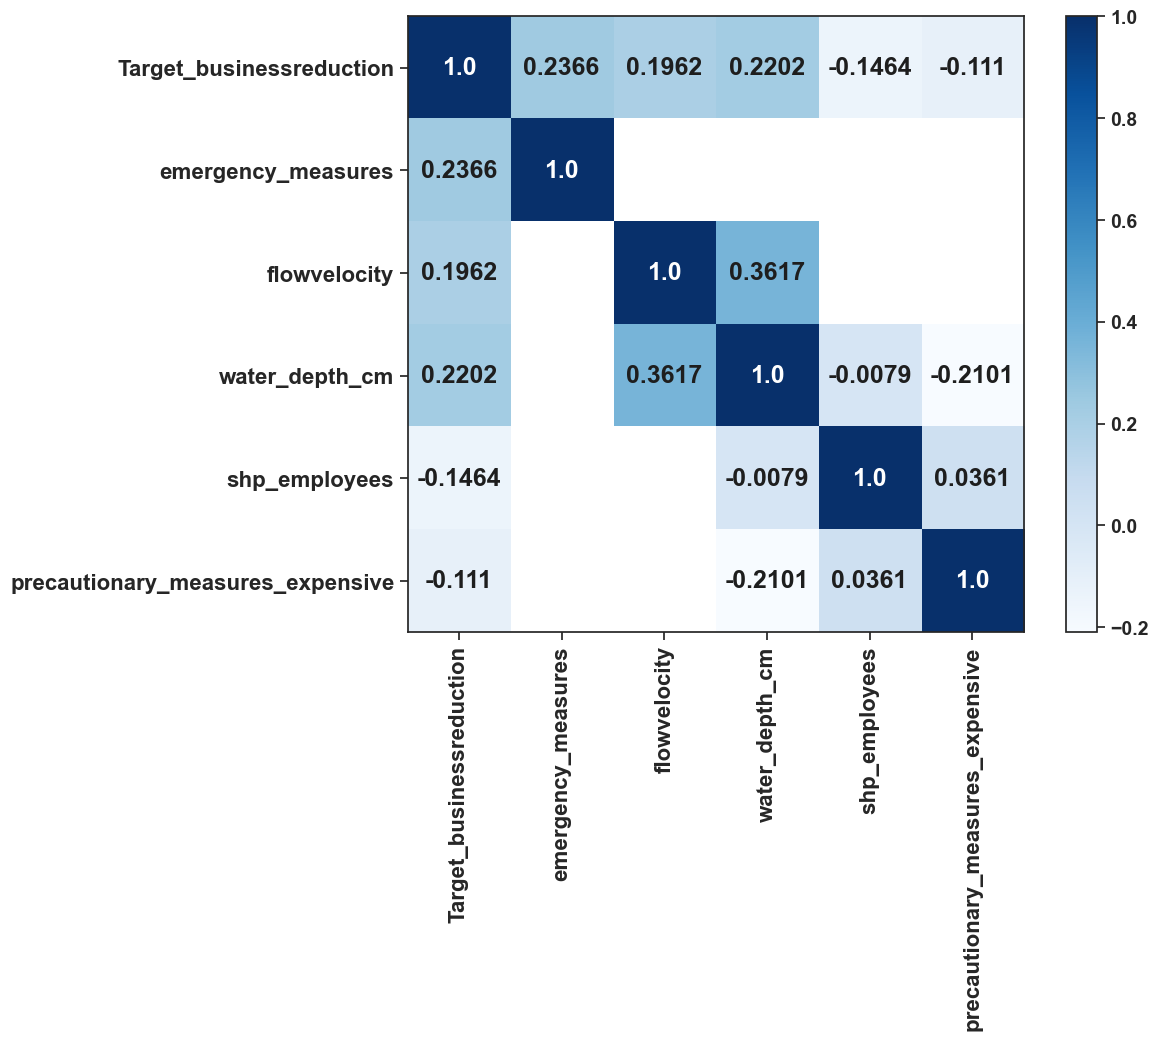

In [295]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_bn,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don"t create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.

# precaution -0.0456 ** (no matter if pre-> wd or wd -> prec)

## Evaluation: HCMC


In [296]:
# condition=[1, 2]
condition=[1, 2, 3, 4, 5]
num_folds = 5
testset_size = int(len(df_hcmc_bn)/num_folds  // 1)

df_hcmc_bn_shuffle = df_hcmc_bn.sample(frac=1).reset_index(drop=True)  # reshuffle samples so that not all zero loss are in one fold
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
residuals = pd.DataFrame()

for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_bn_shuffle[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_bn_shuffle[ ~df_hcmc_bn_shuffle.index.isin(test_nth_fold.index)] # 80% train
    # print(df_hcmc_bn_shuffle.shape , train_nth_fold.shape, test_nth_fold.shape)

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # BN train on fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,  
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix form train
                test_nth_fold,
                Output="mean")    # type of output data
                #Output="median")    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    residuals_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred).astype(int)], axis=1)
    residuals = pd.concat([residuals, residuals_per_fold], axis=0)

    # evaluation metrics
    MAE = em.mean_absolute_error(y_true, y_pred)
    MBE = em.mean_bias_error(y_true, y_pred)
    RMSE = em.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = em.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())



# print(y_pred, y_true)

residuals.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = f"../../model_results/bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = f"../../model_results/bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)



em.empirical_vs_predicted(residuals["y_true"], residuals["y_pred"])


# 5 nodes , no f-exp, incl struct_precausion
# 0  17.562207 -1.082266  23.471596  61.942627 

# 6 nodes nonstruct_prec
# 0  17.364995 -0.865958  23.156208  61.754134 


Scores from fold 0: 17.777725352112675 -1.515908450704225 22.652593062527718 60.50691903615976
Inference - Uncertainty distribution, fold 0:  count    71.000000
mean     19.586331
std       8.286347
min       4.897600
25%      12.681800
50%      18.401700
75%      25.199700
max      39.198400
dtype: float64
Scores from fold 1: 15.599243661971828 -1.428074647887324 23.08894185767687 62.99135329838931
Inference - Uncertainty distribution, fold 1:  count    71.000000
mean     17.005539
std       8.700289
min       4.459300
25%      10.265600
50%      15.971100
75%      21.792450
max      44.386600
dtype: float64


Scores from fold 2: 18.389259154929576 -0.6752366197183101 23.803208998332764 58.72293832407105
Inference - Uncertainty distribution, fold 2:  count    71.000000
mean     20.985096
std       9.451622
min       6.291400
25%      14.681550
50%      19.187800
75%      26.208100
max      50.415600
dtype: float64
Scores from fold 3: 19.194370422535204 -2.040105633802817 23.992672437169727 63.63204938494749
Inference - Uncertainty distribution, fold 3:  count    71.000000
mean     20.068275
std       8.135937
min       3.166100
25%      14.144650
50%      19.350400
75%      23.358600
max      47.054100
dtype: float64
Scores from fold 4: 19.49339718309859 -1.4439239436619709 25.298731008140575 63.08761842505364
Inference - Uncertainty distribution, fold 4:  count     71.000000
mean      19.683361
std       12.343070
min        5.911200
25%       12.474200
50%       17.576100
75%       24.691250
max      100.100000
dtype: float64
Averaged evaluation scores of k-fold cross-validation (mean) :
 

,nobs,median,mean,min max,variance,coef_variation
empirical,355,10.0,18.045070,"[0, 100]",614.72,137.398024
predicted,355,18.0,18.960563,"[3, 100]",91.81,50.535723


### plot obs ~ pred

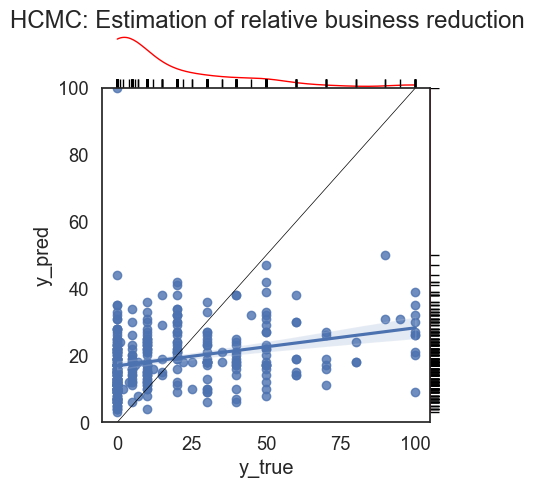

In [297]:
sns.set(style="white", font_scale=1.2)
g = sns.JointGrid(
    x=residuals["y_true"], y=residuals["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color="black", #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={"color": "red", "cut": 0.0, "lw": 1},
)
g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
)
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.suptitle("HCMC: Estimation of relative business reduction")
plt.show()

In [298]:
# # g = sns.jointplot(x=residuals["y_true"], y=residuals["y_pred"],
# #                   #color="blue", 
# #                   height=5, space=0,
# #                   kind="reg",
# #                   # marker="+", s=100, 
# #                   # marginal_kws=dict(fill=False, color="black" ),
# #                   # marginal_kws=dict(bins=50, fill=True),
# # )
# # g = sns.jointplot(
# #     x=residuals["y_true"], y=residuals["y_pred"], #aspect=1.5, 
# #     height=5, space=0, kind="reg", 
# #     marginal_kws=dict(fill=False, color="black" )
# # )

# # g = sns.jointplot(
# #     x=residuals["y_true"], y=residuals["y_pred"], #aspect=1.5, 
# #     height=5, space=0, kind="hex", 
# #     marginal_kws=dict(fill=False, color="black" )
# # )
# sns.set(style="white", font_scale=1.2)
# g = sns.JointGrid(
#     x=residuals["y_true"], y=residuals["y_pred"], 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
#     kind="hex",
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 


# ##########################
# # ## TODO impl
# # sns.set_theme(style="ticks")
# # # Load the planets dataset and initialize the figure
# # g = sns.JointGrid(data=planets, x="year", y="distance", marginal_ticks=True)
# # # Set a log scaling on the y axis
# # g.ax_joint.set(yscale="log")
# # # Create an inset legend for the histogram colorbar
# # cax = g.figure.add_axes([.15, .55, .02, .2])
# # # Add the joint and marginal histogram plots
# # g.plot_joint(
# #     sns.histplot, discrete=(True, False),
# #     cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
# # )
# # g.plot_marginals(sns.histplot, element="step", color="#03012d")
# #############

# # g.plot_joint(sns.kdeplot, color="darkgrey", zorder=0, levels=6)
# # g.plot_marginals(sns.regplot, lowess=True, ci=False,
# #             line_kws={"color": "red", "lw": 1},
# #             scatter_kws={"color": "black", "s": 20})
# g.plot_marginals(
#     sns.distplot, color="black",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
#     # hist_kws={
#     #     "histtype": "bar",  
#     #     "lw": 1, #"bins": "auto", # 10
#     #     "color":"white",
#     #     "edgecolor": "white"}
# )

# # g.plot_joint(sns.kdeplot, color="darkgrey", zorder=0, levels=6)
# # g.plot_marginals(sns.displot, color="black", height=-.15, clip_on=True,
# #                     lw=1, alpha=.005
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
# )
#                 #   kind="kde", color="grey",
#                 #   fill="true", 
#                 #   height=5, space=0, #levels=7
#                 #  )
# x0, x1 = (0,100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.show()




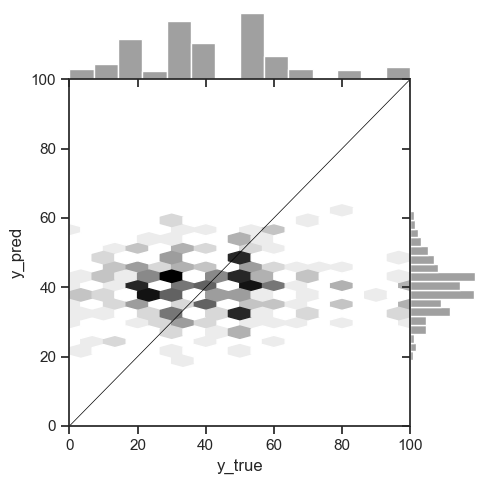

In [314]:
sns.set_theme(style="ticks")

# sns.scatterplot(data=y_pred_org, x="y_true", y="y_pred")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(x=y_pred_org["y_true"], y=y_pred_org["y_pred"],
    kind="hex", color="grey", # color="#4CB391",         
    height=5, space=0)

# bins = create_bins(y_pred_org["y_pred"], bin_size=5)
# ticks = [-2, 20, 40, 60, 80, 102]
# X, Y = np.meshgrid(bins, bins)
# H = np.histogram2d(y_true, y_pred, bins=bins)[0]
# # H_norm: each row describes relative share of all prediction loss bands for businesses of a certain test band
# H_norm = (H.T / H.sum(axis=1)).T
# # cmap = LinearSegmentedColormap.from_list("", ["white", "steelblue"])
# # plt.pcolormesh(Y, X, H_norm, cmap=cmap, rasterized=True) 

x0, x1 = (0,100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


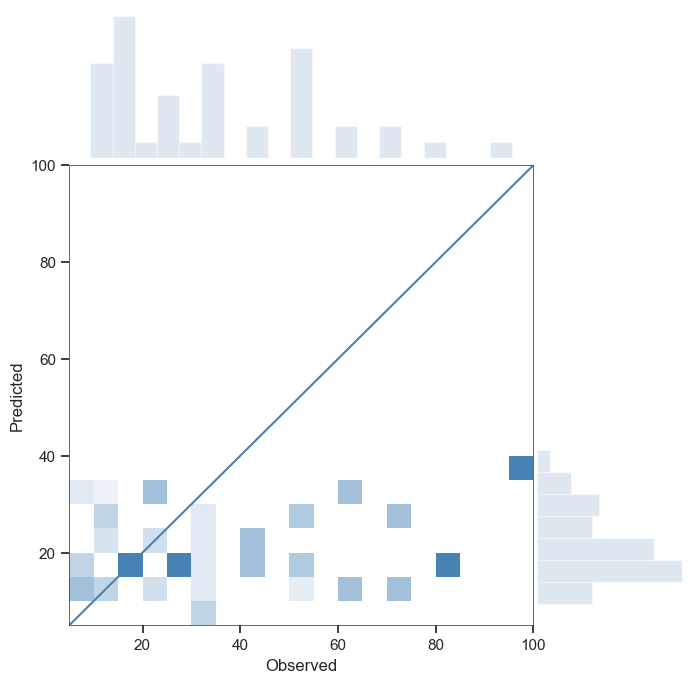

In [305]:
# """
# Comments on binning / categorizing numeric variables

# np.histogram which is being used by plt.hist and sns.histplot defines bins to be left closed/inclusive,
# except the last bin which is closed on both sides, e.g. [0,1,2,3] results in [[0,1), [1,2), [2,3]].

# To be consistent, left closed/inclusive intervals are used as well when categorizing numeric variables with pd.cut.
# Methods, which determine bin edges/breaks, also assume subsequent left closed/inclusive binning.
# """

import math
def age_bins(y, bin_size=1):
    # lower bound inclusive
    min_age = math.floor(y.min())
    # upper bound inclusive for histogram plotting, exclusive for categorizing variables
    max_age = math.ceil(y.max())
    return list(range(min_age, max_age + 1))[0::bin_size]

# age_bins(y_pred_org["y_true"])

from matplotlib.gridspec import GridSpec

def plot_relative_grid(y_true, y_pred, bin_size=5, **kwargs):

    bins = create_bins(y_pred, bin_size=bin_size)
    ticks = [-2, 20, 40, 60, 80, 102]
    X, Y = np.meshgrid(bins, bins)
    H = np.histogram2d(y_true, y_pred, bins=bins)[0]
    # H_norm: each row describes relative share of all prediction loss bands for businesses of a certain test band
    H_norm = (H.T / H.sum(axis=1)).T

    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    cmap = LinearSegmentedColormap.from_list("", ["white", "steelblue"])
    colors = ["lightsteelblue", "lightsteelblue", "plum"]

    ax_scatter.plot([0, 1], [0, 1], transform=ax_scatter.transAxes, color="steelblue")
    ax_scatter.pcolormesh(Y,X, H_norm, cmap=cmap, rasterized=True)   # modified to have y_pred on y-axis
    # ax_scatter.set_yticks(ticks, labels=ticks)
    # ax_scatter.set_xticks(ticks, labels=ticks)

    ax_hist_x.hist(y_true, bins=bins, color=colors[0], alpha=0.4)
    ax_hist_y.hist(y_pred, bins=bins, orientation="horizontal", color=colors[0], alpha=0.4)

    ax_hist_x.set_axis_off()
    ax_hist_y.set_axis_off()
    fig.subplots_adjust(hspace=0.05, wspace=0.02)

    ax_scatter.spines["top"].set_linewidth(0.5)
    ax_scatter.spines["right"].set_linewidth(0.5)
    ax_scatter.spines["left"].set_linewidth(0.5)
    ax_scatter.spines["bottom"].set_linewidth(0.5)

    ax_scatter.set_xlabel("Observed")
    ax_scatter.set_ylabel("Predicted")
    # fig.colorbar(ax_scatter, label="Number of points per pixel", orientation="horizontal")

plot_relative_grid(y_true, y_pred)
#plot_relative_grid(y_pred_org["y_true"], y_pred_org["y_pred"])
plt.show()

# TODO rmeove shift to right 
# TODO implement colorbar horizontal with Number of points per pixel

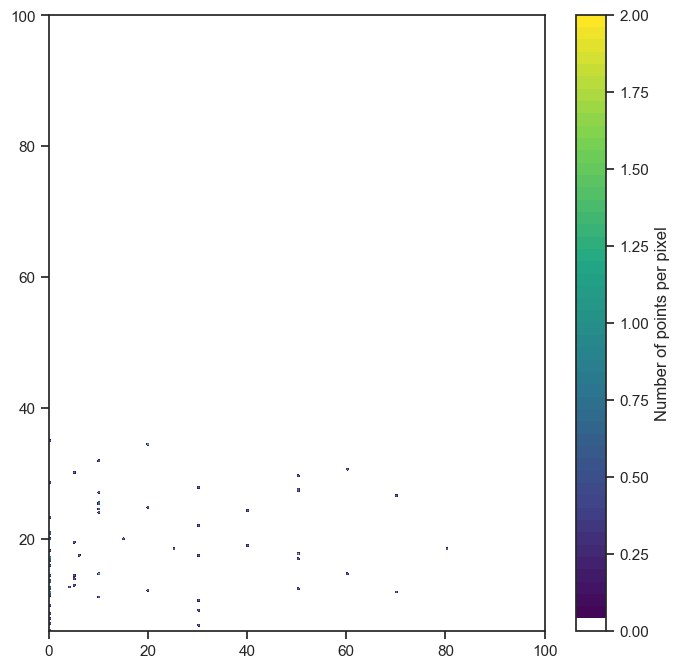

In [270]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
fig.colorbar(ax.scatter_density(x=y_true, y=y_pred, cmap=white_viridis), label="Number of points per pixel")

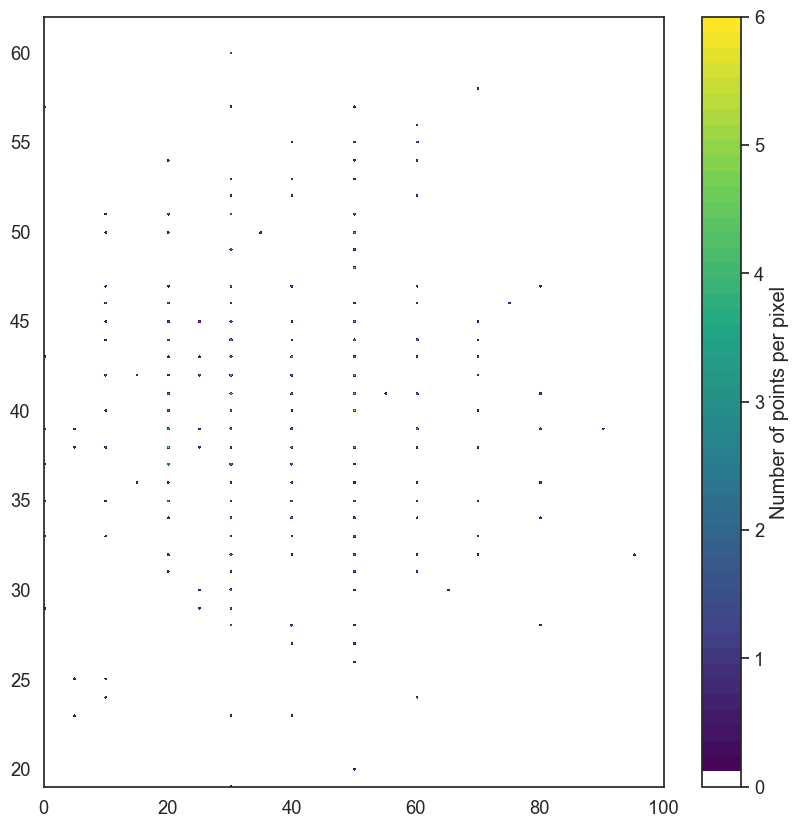

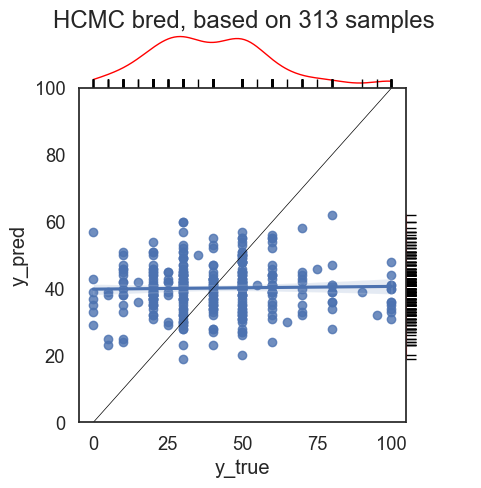

In [253]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (0.001, "#440053"),
    # (1e-20, "#440053"),
    (0.2, "#404388"),
    (0.4, "#2a788e"),
    (0.6, "#21a784"),
    (0.8, "#78d151"),
    (1, "#fde624"),
], N=50)# N=256)


sns.set(style="white", font_scale=1.2)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")


g = sns.JointGrid(
    x=y_pred_org["y_true"], y=y_pred_org["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 
# cb = fig.colorbar(g, label="counts") # ax=ax 

g.plot_marginals(
    sns.distplot, color="black", #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={"color": "red", "cut": 0.0, "lw": 1},
)
g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
                )
density = ax.scatter_density(
    x=y_pred_org["y_true"], y=y_pred_org["y_pred"], 
    cmap=white_viridis,
)
fig.colorbar(density, label="Number of points per pixel")

x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
plt.suptitle(f"HCMC bred, based on {y_pred_org.shape[0]} samples")


plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


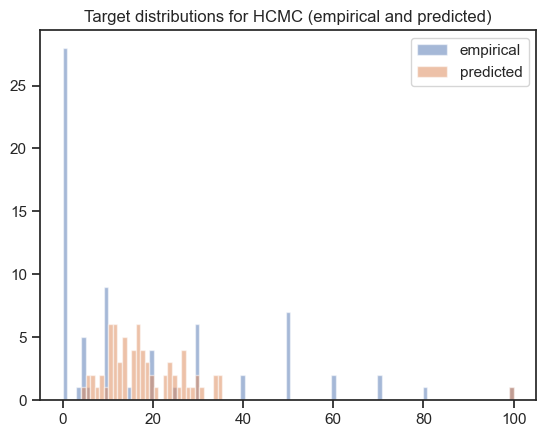

In [35]:

bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.5, label="empirical")
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.5, label="predicted")
plt.legend(loc="upper right")
plt.title("Target distributions for HCMC (empirical and predicted)")
plt.show()


### plot obs ~ pred -confidence intervalls

In [36]:
# condition=[1, 2, 3]
# values = df_hcmc_bn.iloc[:,condition].to_numpy()

# F = inference(condition,        # nodes that will be conditionalized
#               values,           # information used to conditionalize the
#                                 # nodes of the NPBN
#               R,                # the rank correlation matrix 
#               df_hcmc_bn, # DataFrame with df_hcmc
#              # Output="mean")    # type of output data
#               Output="median")    # type of output data

y_pred = F.squeeze()
y_true=df_hcmc_bn.iloc[:,0].to_numpy()
#?np.squeeze
# np.mean(
np.abs(y_pred-y_true)

ValueError: operands could not be broadcast together with shapes (313,) (356,) 

#### Main validation results

In [173]:
## get daamge / total
c = "y_pred"
print(len(np.where(residuals[c] > 0.0)[0])) 
print(len(np.where(residuals[c] > 0.0)[0]) / len(residuals[c]) * 100, "%")
np.mean(residuals[c])


355
100.0 %


0.5859154929577465

In [174]:

residuals_hcmc = pd.DataFrame(
            {
                "y_true": residuals["y_true"],
                "y_pred": residuals["y_pred"],
                "residuals": residuals["y_true"] - residuals["y_pred"],
            },
            index=residuals["y_true"].index,
        )
print(residuals_hcmc.describe())


for c in residuals_hcmc.columns:
    ci = calc_confidence_interval(data=residuals_hcmc[c], confidence_level=0.95)
    counts = ((residuals_hcmc[c].values > ci[0]) & (residuals_hcmc[c].values <= ci[1])).sum(axis=0)
    print(c, "confidence interval:", ci, f"\ncases within interval: {counts}")


          y_true      y_pred   residuals
count  355.00000  355.000000  355.000000
mean    18.04507   18.960563   -0.915493
std     24.79357    9.581858   23.814103
min      0.00000    3.000000 -100.000000
25%      0.00000   12.000000  -15.000000
50%     10.00000   18.000000   -9.000000
75%     30.00000   24.000000    7.500000
max    100.00000  100.000000   91.000000
y_true confidence interval: [15.46 20.63] 
cases within interval: 29
y_pred confidence interval: [17.96 19.96] 
cases within interval: 38
residuals confidence interval: [-3.4   1.57] 
cases within interval: 24


Actual zero-loss: 49, 
Actual damage: 50 

Predict as zero-loss: 93, 
Predict as damage: 6 


### Inference

In [ ]:
#-----------------------------------------------------------------------------
# Function 5 - inference - making inference with the BN model
#-----------------------------------------------------------------------------

condition=[1, 2, 3] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
# condition=[1, 2, 3, 4, 5, 6, 7] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              df_hcmc_bn, # DataFrame with df_hcmc
             # Output="mean")    # type of output data
              Output="median")    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())


## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_true=df_hcmc_bn.iloc[:,0].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_true - y_true.mean(axis=0))/y_true.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate evaluation metrics
MAE = np.mean(np.abs(y_pred-y_true))
MBE = np.mean(y_pred-y_true)
RMSE = (np.mean((y_pred-y_true)**2))**(1/2)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  


ValueError: Data must be 1-dimensional, got ndarray of shape (353, 3) instead

In [ ]:
y_pred_org = pd.concat([pd.Series(y_true), pd.Series(y_pred.astype(int))], axis=1)
y_pred_org.columns = ["y_true", "y_pred"]
print(y_pred_org.describe())


           y_true     y_pred
count   70.000000  70.000000
mean    17.985714   9.628571
std     25.323125  12.132328
min      0.000000   0.000000
25%      0.000000   0.000000
50%      5.000000   5.000000
75%     30.000000  10.000000
max    100.000000  50.000000


(-12.474265828714783, 112.47426582871478)

In [ ]:
## resilneceLeftAlon
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA ***
# MAE, MBE, RMSE, R2: 17.200156373937677 0.4218543909348444 23.15446102273047 0.10639659042647506
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, employees -> resilLA (sm shp feel left alon) ***
# MAE, MBE, RMSE, R2: 17.176264589235128 0.4530617563739379 23.124443137322782 0.108357373657999
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, employees -> resilLA -> emerg
# MAE, MBE, RMSE, R2: 17.1957447592068 0.5416563739376764 23.123202603045744 0.10895224317309785

## resilience  + precaution
## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA, prec_cheap *********
# MAE, MBE, RMSE, R2: 17.027345609065158 -0.01665269121813176 23.048158649799895 0.11250114114029462
## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA -> prec_cheap,  *********
# MAE, MBE, RMSE, R2: 17.025917847025497 -0.04757223796034028 23.049739182418246 0.11223725255180217

## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA, prec_cheap -> wd
# MAE, MBE, RMSE, R2: 17.03888611898017 -0.029772237960340845 23.053894013392544 0.11193013239781474
                                                                

In [ ]:
# y_pred_org = pd.concat([pd.Series(y_true), pd.Series(y_pred.astype(int))], axis=1)
# y_pred_org.describe()


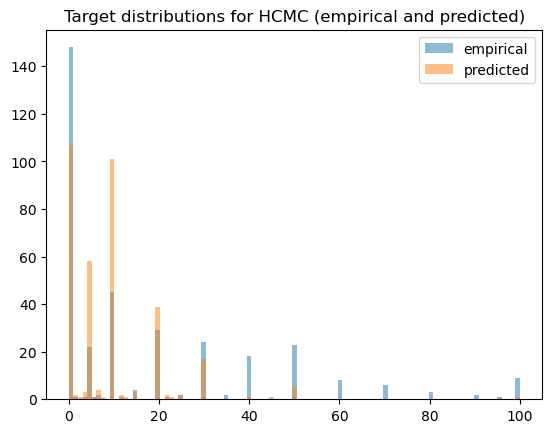

In [ ]:
## bred for CanTHo (all sectors)
## 1 feature (fv) (predictor with strongest unconditional correlation to target)
# MAE, MBE, RMSE, R2: 19.505287818696882 3.023567138810198 24.160341209664693 0.04181915781958483

## 2 features (fv , eme): 
# MAE, MBE, RMSE, R2: 19.74858300283286 4.847018130311617 24.102795696439568 0.07470495711283799
## 2 features (fv -> eme):  **
# MAE, MBE, RMSE, R2: 19.50758866855524 4.4753994334277625 23.847507546059752 0.08311888467028201


## 3 features (fv -> eme, wd): 
# MAE, MBE, RMSE, R2: 19.812639376770537 4.699533994334278 24.505799118556922 0.05333127112893681
# (fv, wd) -> emer                                                                
# MAE, MBE, RMSE, R2: 19.681899150141643 5.419263456090651 24.4689403027466 0.0773554306974711
## 3 features (wd -> fv -> eme): 
# MAE, MBE, RMSE, R2: 19.35493597733711 4.44363059490085 24.164246571908436 0.07249607165736519
# wd -> fv -> emerg, wd -> emer    **
# MAE, MBE, RMSE, R2: 19.268610198300284 4.345695750708216 24.10171438023097 0.07410980916779679

## 4 features  wd -> fv -> emerg, wd -> emer , bage OR wd -> fv -> emerg, wd -> emer, bage -> emer 
# MAE, MBE, RMSE, R2: 22.523064589235126 9.747832861189801 30.487814466673964 0.04561359169218263

## 4 features  wd -> fv -> emerg, wd -> emer , employees 
# MAE, MBE, RMSE, R2: 18.175970538243625 1.9748232294617563 23.62099298041095 0.0823823705515876

## 4 features  wd -> fv -> emerg, wd -> emer , employees -> emerg **
# MAE, MBE, RMSE, R2: 18.114451558073654 2.0018022662889505 23.521324314751425 0.08837952332919242


## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg **
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419

# 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682

## NOTE flood_experience destn had much to the correlation matrix
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg ***
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419
# MAE, MBE, RMSE, R2: 18.049626912181303 1.9718960339943339 23.472259684081735 0.09114064236879915

## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, wd -> f_exp  or (fv, wd ) -> f_exp
# MAE, MBE, RMSE, R2: 18.04273852691218 1.8733560906515578 23.485209176707 0.08947400855478219
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, empyees -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.151970254957504 2.005811614730878 23.605126298988313 0.08341479771829687
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, fv -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.087845042492916 1.9727124645892347 23.54767208649904 0.08669006220384032
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, (fv, wd) -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.033663456090654 1.906552407932011 23.483206802412496 0.090087138456569
# MAE, MBE, RMSE, R2: 18.07102379603399 1.963625495750708 23.48455980772728 0.09018022497710662
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, empyees -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.151970254957504 2.005811614730878 23.605126298988313 0.08341479771829687
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, fv -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.087845042492916 1.9727124645892347 23.54767208649904 0.08669006220384032

## NOTE flood_experience doestn add much to the correlation matrix . corr ~ 0.02
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg **
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419
# MAE, MBE, RMSE, R2: 18.049626912181303 1.9718960339943339 23.472259684081735 0.09114064236879915
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, wd -> f_exp  or (fv, wd ) -> f_exp
# MAE, MBE, RMSE, R2: 18.04273852691218 1.8733560906515578 23.485209176707 0.08947400855478219
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, (fv, wd) -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.033663456090654 1.906552407932011 23.483206802412496 0.090087138456569
# MAE, MBE, RMSE, R2: 18.07102379603399 1.963625495750708 23.48455980772728 0.09018022497710662

## NOTE decrease in BN by adding barea or content value as 5th var (insted f exp)


In [ ]:
## bred for HCMC (all sectors)

## 1 feature (fv) (predictor with strongest unconditional correlation to target)
# MAE, MBE, RMSE, R2: 19.505287818696882 3.023567138810198 24.160341209664693 0.04181915781958483

## 2 features (fv , wd): 
#MAE, MBE, RMSE, R2: 19.666353824362606 4.0971328611898015 24.724952060748617 0.0445429230009319
## 2 features (fv -> wd):
# MAE, MBE, RMSE, R2: 19.27965014164306 3.0124597733711056 24.42307087930957 0.03853784201023082
## 2 features (wd -> fv): *** 
# MAE, MBE, RMSE, R2: 19.19400849858357 3.0263410764872525 24.32564070748576 0.04346755981646989

## 3 features (fv -> wd, ind) or 3 features (fv -> wd, ind-> wd): 
# MAE, MBE, RMSE, R2: 19.85800424929178 3.829028611898017 26.26434191775025 0.021068001106892515
## 3 features (inund -> fv -> wd): 
# MAE, MBE, RMSE, R2: 20.061832861189803 4.209602266288951 26.296466395722444 0.022958052067840833
## 3 features (fv -> inund -> wd) or (fv -> wd -> inund): 
# MAE, MBE, RMSE, R2: 20.360632577903683 5.158526628895184 26.629869881681152 0.028134408947895335
## 3 features (fv -> wd, f_exp): 
# MAE, MBE, RMSE, R2: 19.49173371104816 3.5954328611898014 24.485946638578397 0.04108387664484545
## 3 features (fv -> wd, fv -> f_exp) or (fv -> wd, wd -> f_exp): 
# MAE, MBE, RMSE, R2: 19.437306232294617 3.5750371104815866 24.4236399033457 0.04324104053604041
# MAE, MBE, RMSE, R2: 19.4146730878187 3.5007552407932008 24.4052399553994 0.04337155544398731

## 3 features (fv -> wd, b area): 
# MAE, MBE, RMSE, R2: 19.694199716713882 3.3882450424929176 25.499697335228188 0.016091008515160106
## 3 features (b area -> fv -> wd, ) or ( (b area, fv) -> wd, )
# MAE, MBE, RMSE, R2: 19.644013597733707 3.452292351274788 25.443190103627895 0.018462419021187275
# MAE, MBE, RMSE, R2: 19.632755524079318 3.3500699716713886 25.43108857960936 0.01756801044079168


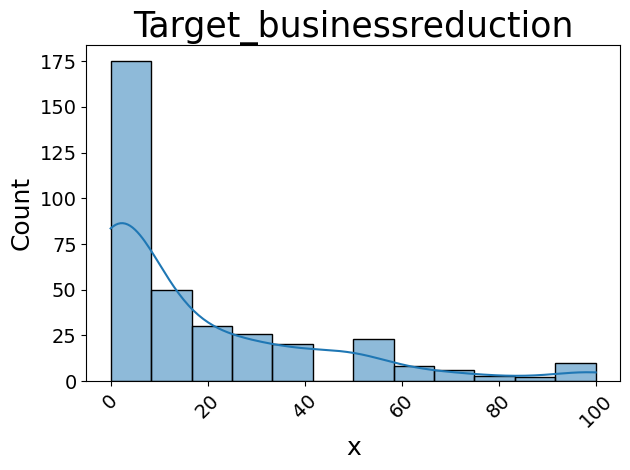

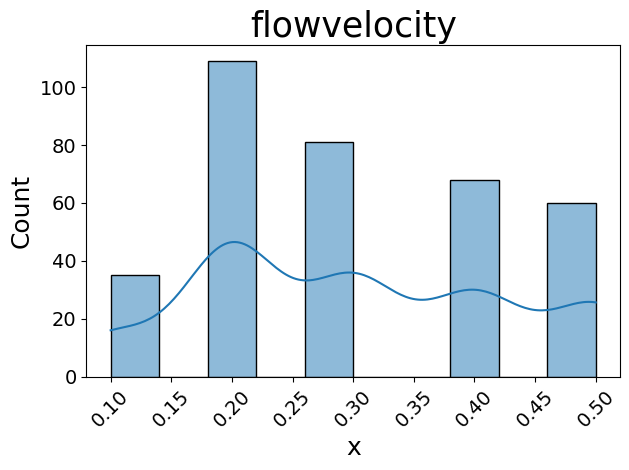

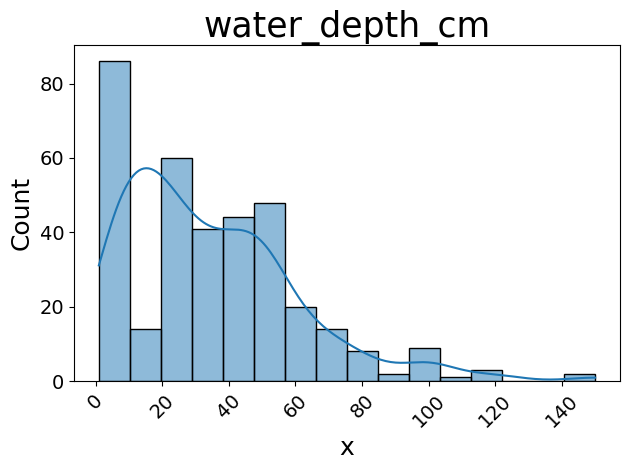

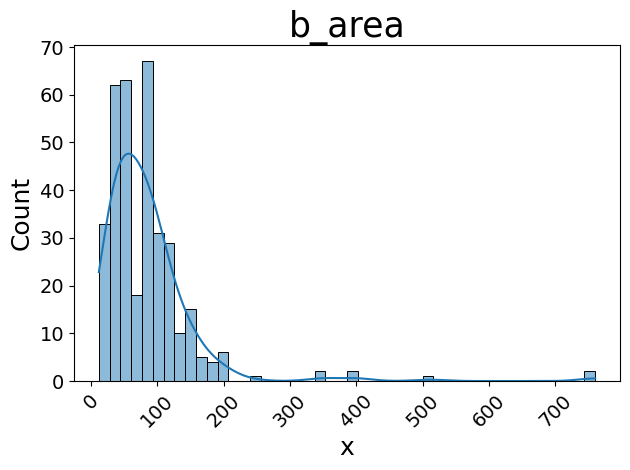

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\bayesian_networks\\BN_visualize_bn_Target_businessreduction_margins.pdf'

In [ ]:
#-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             df_hcmc_bn.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             df_hcmc_bn.columns,                      # names of variables
             data = df_hcmc_bn,                       # df_predictorsFrame with df_hcmc
             fig_name = fig_name + "_margins")  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


In [ ]:
M

,Var1,Var2,r,Clayton,Frank,Gaussian,Gumbel
0,Target_businessreduction,flowvelocity,0.210109,6.012881,5.971961,5.686417,6.066955
1,Target_businessreduction,emergency_measures,0.240895,5.032199,5.214118,4.957898,5.456367
2,Target_businessreduction,water_depth_cm,0.243223,3.183184,3.156921,3.1288,3.549979
3,Target_businessreduction,shp_employees,-0.135788,12.400164,10.95412,10.497397,12.400209
4,Target_businessreduction,resilienceLeftAlone,-0.068287,5.652953,6.312775,6.417777,5.551841
5,flowvelocity,emergency_measures,0.109866,5.406649,5.212604,5.030003,5.278949
6,flowvelocity,water_depth_cm,0.369483,3.827302,3.038438,2.980447,3.196644
7,flowvelocity,shp_employees,0.05103,11.022934,10.930145,10.82018,10.808764
8,flowvelocity,resilienceLeftAlone,0.080447,6.65064,6.378596,6.270158,6.671966
9,emergency_measures,water_depth_cm,0.095059,2.40472,2.293887,2.307836,2.399759


<Figure size 2000x1500 with 0 Axes>

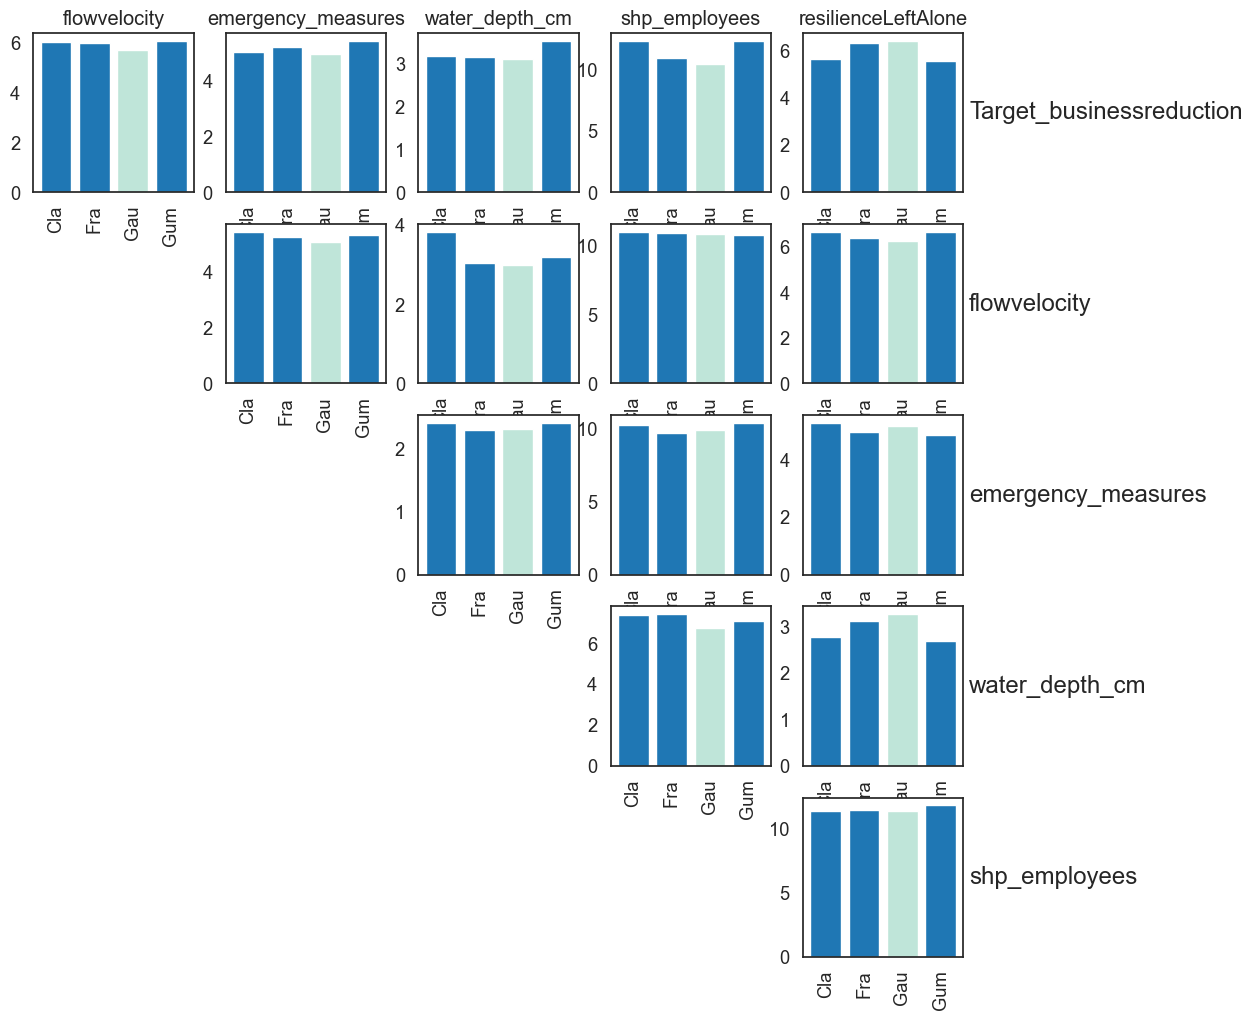

In [ ]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------
plt.figure(figsize=(20,15))
M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
                  names = df_hcmc_bn.columns,   # names of variables
                  plot = True,               # create a plot (0=don"t create plot)
                  fig_name = fig_name)    # figure name


# Text for example case:                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


## !! decalibration score = overall score if BN fullfills 

In [ ]:
M

,Var1,Var2,r,Clayton,Frank,Gaussian,Gumbel
0,Target_relative_contentloss_euro,flowvelocity,0.263828,1.014663,0.829228,0.816773,0.895479
1,Target_relative_contentloss_euro,shp_registered_capital_euro,0.273843,0.274814,0.169969,0.170619,0.142091
2,Target_relative_contentloss_euro,shp_employees,0.105858,2.250071,1.940503,1.860467,1.845609
3,Target_relative_contentloss_euro,b_area,-0.045066,0.060234,0.074083,0.06343,0.049957
4,Target_relative_contentloss_euro,bage,-0.266082,0.084048,0.080713,0.071532,0.084046
5,Target_relative_contentloss_euro,shp_avgmonthly_sale,0.283974,1.788844,1.506169,1.479901,1.494931
6,Target_relative_contentloss_euro,hh_monthly_income,0.119853,1.798456,1.69679,1.497202,1.540063
7,Target_relative_contentloss_euro,inundation_duration_h,0.19021,0.41297,0.376379,0.389603,0.434001
8,Target_relative_contentloss_euro,water_depth_cm,0.413043,0.307181,0.190514,0.233761,0.269286
9,Target_relative_contentloss_euro,emergency_measures,0.125531,0.447025,0.566304,0.579871,0.447029


##### d-calibration score

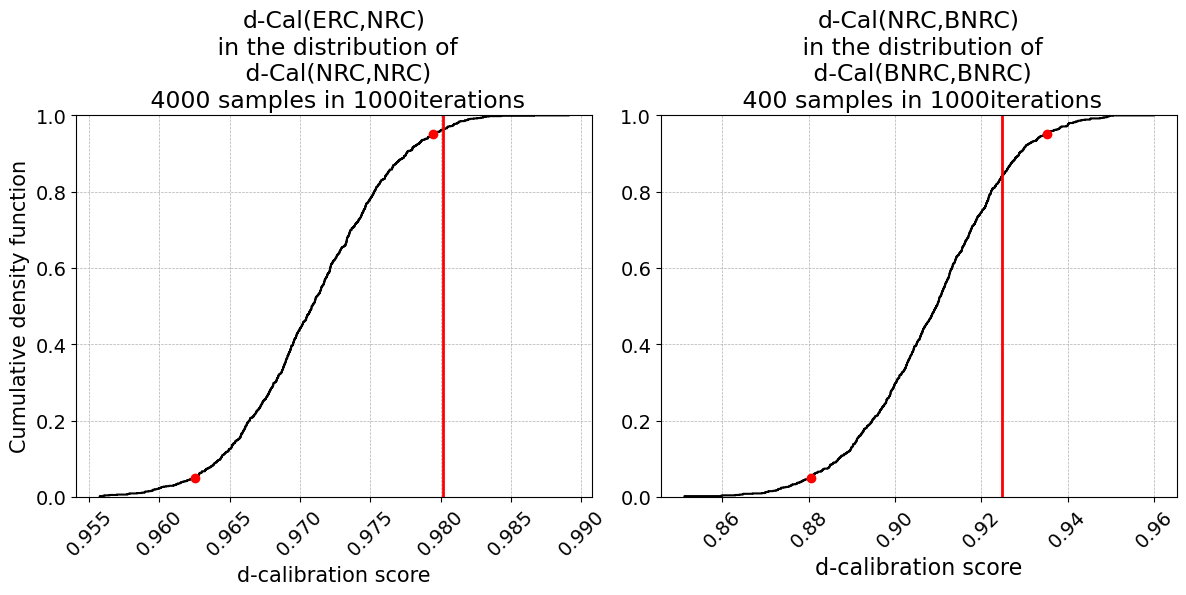

FAILURE: The d-Cal of the empirical rank correlation matrix (ERC) is out of the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

SUCCESS: The d-Cal of the normal rank correlation matrix (NRC) fall between the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [ ]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------


# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            df_hcmc_bn,     # df_predictorsFrame with df_hcmc
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don"t create plot)
                            Type="H",           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN"s rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictorssets.


In [ ]:
df_hcmc.head(2)#.shape

,Target_businessreduction,flowvelocity,emergency_measures,water_depth_cm,bage,inundation_duration_h,shp_employees,flood_experience,resilienceLeftAlone,shp_content_value_euro,precautionary_measures_lowcost,b_area,resilience,precautionary_measures_expensive,hh_monthly_income_euro,shp_avgmonthly_sale_euro,contaminations
0,0,0.2,0.0,10.0,12.0,2.0,1,76,2.0,441.9,0.0,25.0,5.0,0.0,110.5,276.2,0
1,0,0.2,0.0,15.0,0.0,2.0,1,76,1.0,441.9,0.0,21.0,5.0,0.0,294.6,276.2,1


## Model transferability
Test trained NPBN for CanTHo DS

In [272]:
infile_name = "input_data_businessreduction_cantho"
df_cantho = pd.read_excel(f"../input_survey_data/{infile_name}.xlsx")

## prepare CanTHo for BN - adpat with same column structure as training dataset
df_cantho = df_cantho.loc[df_cantho.shp_employees < 10, :]
df_cantho_bn = df_cantho[df_hcmc_bn.columns]
 
print(df_cantho_bn.shape)
df_cantho_bn.tail(2)

(313, 6)


,Target_businessreduction,emergency_measures,flowvelocity,water_depth_cm,shp_employees,precautionary_measures_expensive
311,50,0.444444,0.4,20,4,0.666667
312,50,0.111111,0.3,50,1,0.333333


### Prediction and Evaluation on CanTho Bred

In [276]:
condition=[1, 2, 3, 4, 5,] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_cantho_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              Output="mean")    # type of output data
              #Output="median")    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())  #y_pred freq

## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_true=df_cantho_bn.iloc[:,0].to_numpy()

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_bn.iloc[:,0].to_numpy()


# evaluation metrics
MAE = em.mean_absolute_error(y_true, y_pred)
MBE = em.mean_bias_error(y_true, y_pred)
RMSE = em.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = em.symmetric_mean_absolute_percentage_error(y_true, y_pred)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

print(f"\nObserved and predicted target distribution for CanTho:")
em.empirical_vs_predicted(y_true, y_pred)

Inference - Uncertainty distribution:  count    313.000000
mean      41.594286
std        7.407433
min       20.157100
25%       36.754800
50%       41.475000
75%       45.950000
max       63.052800
dtype: float64
MAE,: 17.769447284345045
MAE, MBE, RMSE, SMAPE: 17.769447284345045 -0.7316664536741215 22.91460562401669 23.425976417449675

Observed and predicted target distribution for CanTho:


,nobs,median,mean,min max,variance,coef_variation
empirical,313,40.0,40.862620,"[0, 100]",477.46,53.473876
predicted,313,41.0,41.115016,"[20, 63]",54.86,18.015527


#### Main validation results


In [99]:
## get daamge / total
len(np.where(y_pred>0)[0])
np.mean(y_pred)

40.67742364217253

In [141]:
residuals_cantho = pd.DataFrame(
            {
                "y_true": y_true,
                "y_pred": y_pred,
                "residuals": y_true - y_pred,
            },
            index=range(len(y_true.flatten())),
        )
print(residuals_cantho.describe())


for c in residuals_cantho.columns:
    ci = em.calc_confidence_interval(data=residuals_cantho[c], confidence_level=0.95)
    counts = ((residuals_cantho[c].values > ci[0]) & (residuals_cantho[c].values <= ci[1])).sum(axis=0)
    print(c, "confidence interval:", ci, f"\ncases within interval: {counts}")


           y_true      y_pred   residuals
count  313.000000  313.000000  313.000000
mean    40.862620   40.677424    0.185196
std     21.850827    7.489526   22.941882
min      0.000000   21.172300  -55.976600
25%     25.000000   35.819700  -16.435100
50%     40.000000   40.665100   -1.250800
75%     50.000000   44.960200   13.374800
max    100.000000   62.381900   69.225300
y_true confidence interval: [38.43 43.29] 
cases within interval: 39
y_pred confidence interval: [39.84 41.51] 
cases within interval: 34
residuals confidence interval: [-2.37  2.74] 
cases within interval: 33


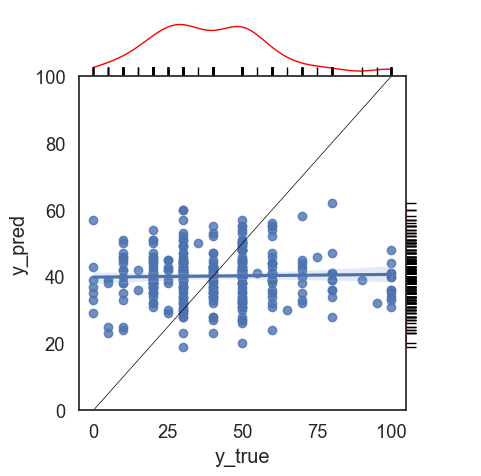

In [39]:
sns.set(style="white", font_scale=1.2)
g = sns.JointGrid(
    x=y_pred_org["y_true"], y=y_pred_org["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color="black", #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={"color": "red", "cut": 0.0, "lw": 1},
)


g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
)
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("Model transferability, tested on Can Tho dataset")
plt.show()

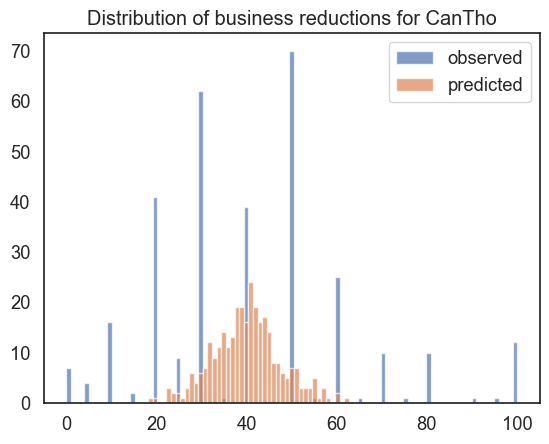

In [40]:
bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.7, label="observed")
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.7, label="predicted")
plt.legend(loc="upper right")
plt.title("Distribution of business reductions for CanTho")
plt.show()


In [51]:
df_hcmc_bn.describe()

,Target_businessreduction,emergency_measures,flowvelocity,water_depth_cm,shp_employees,precautionary_measures_expensive
count,353.000000,353.000000,353.000000,352.000000,353.000000,353.000000
mean,17.807365,0.408876,0.302550,34.497159,1.847025,0.153919
std,24.461293,0.263145,0.125767,26.306218,1.186739,0.194409
min,0.000000,0.000000,0.100000,1.000000,1.000000,0.000000
25%,0.000000,0.166667,0.200000,15.000000,1.000000,0.000000
50%,10.000000,0.500000,0.300000,30.000000,2.000000,0.000000
75%,30.000000,0.500000,0.400000,50.000000,2.000000,0.333333
max,100.000000,1.000000,0.500000,150.000000,9.000000,1.000000


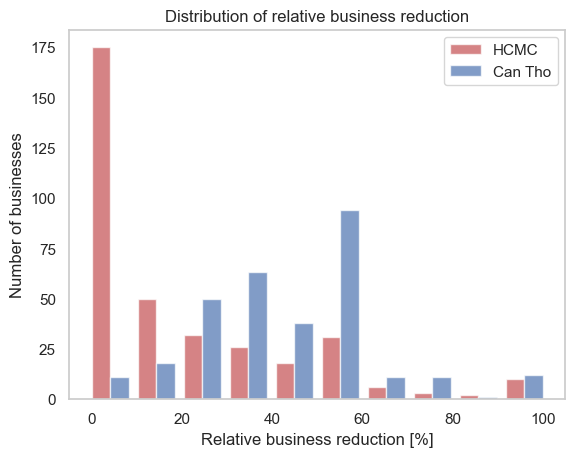

In [54]:
#bins = np.linspace(0, 100, 100)
#plt.hist(df_hcmc_bn["Target_businessreduction"], bins, alpha=0.7, label="HCMC")
#plt.hist(df_cantho["Target_businessreduction"], bins, alpha=0.7, label="Can Tho")

import seaborn as sns

# sns.set_theme()  # <-- This actually changes the look of plots.
sns.set_style("whitegrid", {"axes.grid" : False})
fig, ax = plt.subplots()
plt.hist(
    [
        df_hcmc_bn["Target_businessreduction"], 
        df_cantho_bn["Target_businessreduction"]
    ], 
    color=["r","b"], alpha=0.7,  
    label=["HCMC", "Can Tho"],
    # bins=range(-1, 101, 10)
    bins = np.linspace(-1, 101, 11)
)

# TODO make to 10 bins with equal ranges

plt.legend(loc="upper right")
plt.xlabel("Relative business reduction [%]")
plt.ylabel("Number of businesses")
plt.title("Distribution of relative business reduction")# (source: survey datasets)
plt.show()

In [46]:
print(df_hcmc_bn["Target_businessreduction"].value_counts())
df_cantho_bn["Target_businessreduction"].value_counts()

Target_businessreduction
0      147
10      45
20      29
30      24
50      23
5       22
40      18
100      9
60       8
70       6
15       4
80       3
35       2
90       2
25       2
7        2
12       1
6        1
2        1
1        1
22       1
95       1
4        1
Name: count, dtype: int64


Target_businessreduction
50     69
30     62
20     41
40     38
60     24
10     16
100    11
80     10
70     10
25      9
0       7
5       4
15      2
35      1
95      1
55      1
90      1
65      1
75      1
Name: count, dtype: int64